# Example to calculate photon-ALP oscillations from PKS 2155-304 including the intergalactic magnetic field

This notebook demonstrates how to calculate the photon-ALP transition probability for PKS 2155-304 taking into account the intergalactic mangetic field (IGMF) and the magnetic field of the Milky Way. The IGMF is modelled with a cell-like structure: in each cell the field strength is constant but the orientation changes randomly from one cell to the next.

In [1]:
from gammaALPs import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from ebltable.tau_from_model import OptDepth
from astropy import constants as c
from myplot.funcs import *

In [2]:
%matplotlib inline

### Set the ALP

Initialize an ALP object, that stores the ALP mass $m$ (in neV) and the coupling $g$ (in $10^{-11}\mathrm{GeV}^{-1}$).

In [3]:
m, g = 0.1,1.
alp = ALP(m,g)

## Set the source

Set the source properties (redshift and sky coordinates) in the ```Source``` containier

In [4]:
pks2155 = Source(z =  0.116, ra = '21h58m52.0s', dec = '-30d13m32s')
print pks2155.z
print pks2155.ra, pks2155.dec
print pks2155.l, pks2155.b

0.116
-52.2456161104 -30.2255555556
17.730509236 -52.2456161104


### Init the module list

Initialize the list of transfer modules that will store the different magnetic field environments. 

Energies are supplied in GeV as ```numpy.ndarray```

In [5]:
EGeV = np.logspace(1.,5.,200)

Now initialize the initial photon polarization. Since we are dealing with a gamma-ray source, no ALPs are initially present in the beam (third diagonal element is zero). The polarization density matrix is normalized such that its trace is equal to one, $\mathrm{Tr}(\rho_\mathrm{in}) = 1$.

In [6]:
pin = np.diag((1.,1.,0.)) * 0.5

In [7]:
m = ModuleList(alp, pks2155, pin = pin, EGeV = EGeV)

### Add modules:

Now we add propagation modules for the IGMF, which includes EBL absorption, and the Galactic magnetic field.

In [8]:
m.add_propagation("IGMF", 
                  0, # position of module counted from the source. 
                  nsim = 10, # number of random B-field realizations
                  B0 = 1e-3,  # B field strength in micro Gauss at z = 0
                  n0 = 1e-7,  # normalization of electron density in cm^-3 at z = 0
                  L0 = 1e3, # coherence (cell) length in kpc at z = 0
                  eblmodel = 'dominguez' # EBL model
                  )
m.add_propagation("GMF",1, model = 'jansson12', model_sum = 'ASS') # finally, the beam enters the Milky Way Field

/Users/manuelmeyer/projects/python/ebltable/ebltable/tau_from_model.py:302: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  RuntimeWarning)


We can also change the ALP parameters before running the modules:

In [9]:
m.alp.m = 0.01
m.alp.g = 5.

### Run all modules

Now we run the modules. If ```multiprocess``` key word is larger than two, this will be split onto multiple cores with python's ```multiprocess``` module.

The ```px,py,pa``` variables contain the mixing probability into the two photon polarization states (x,y) and into the axion state (a).

In [10]:
px,py,pa = m.run(multiprocess=2)

## Plot the output 

Calculate the case for EBL absorption only as well for plotting:

In [11]:
tau = m.modules[0].t.opt_depth(m.source.z, m.EGeV / 1e3)

(10, 200)
4.14845568945e-06
1.46973440056e-05


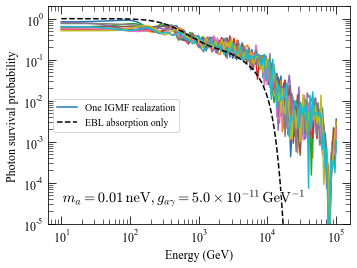

In [12]:
pgg = px + py # the total photon survival probability

print pgg.shape
print np.min(np.median(pgg, axis = 0))
print np.min(np.max(pgg, axis = 0))

for i,p in enumerate(pgg): # plot all realizations
    plt.semilogx(m.EGeV, p, label = 'One IGMF realazation' if not i else '')
plt.semilogx(m.EGeV, np.exp(-tau), label = 'EBL absorption only',
            color = 'k', ls = '--')

plt.xlabel('Energy (GeV)')
plt.ylabel('Photon survival probability')
plt.legend(loc = 'center left', fontsize = 'medium')

plt.annotate(r'$m_a = {0:.2f}\,\mathrm{{neV}}, g_{{a\gamma}} = {1:.1f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(m.alp.m,m.alp.g),
             xy = (0.05,0.1), size = 'x-large', xycoords = 'axes fraction', ha = 'left',**effect)

plt.gca().set_ylim(1e-5,2.)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.subplots_adjust(left = 0.2)

# Save results

Save the results in an astropy table. 

In [13]:
from astropy.table import Table

In [14]:
c = {}
c['pgg'] = np.vstack((EGeV, pgg))
t = Table(c)

In [15]:
t.write('pks2155_igmf.fits', overwrite = True)

In [16]:
t1 = Table.read('pks2155_igmf.fits')

In [17]:
t1

pgg [200]
float64
10.0 .. 100000.0
0.837371419768 .. 0.00180129866502
0.559213356337 .. 0.00168808656548
0.628337876599 .. 0.00301075143173
0.526433348756 .. 0.00257323108966
0.802063962998 .. 0.00185642294719
0.625649470734 .. 0.00356455761636
0.573096587735 .. 0.00198090193764
0.763570298048 .. 0.000557900336542
